In [16]:
!pip install google-generativeai
!pip install spacy

In [17]:
import re

def clean_text(text):
    """
    Очищает текст от мусора:
    - Приводит к нижнему регистру.
    - Удаляет цифры.
    - Удаляет знаки препинания и специальные символы.
    - Заменяет множественные пробелы на одиночные.
    """
    text = text.lower() # Приводим к нижнему регистру
    text = re.sub(r'\d+', '', text) # Удаляем цифры
    text = re.sub(r'[^\w\s]', '', text) # Удаляем все, кроме букв и пробелов
    text = re.sub(r'\s+', ' ', text).strip() # Заменяем множественные пробелы на один и удаляем пробелы по краям
    return text

# Интеграция в load_texts_from_directory:
# Найдите вашу функцию load_texts_from_directory в вашем research_draft.py
# и добавьте вызов clean_text внутри цикла, вот так:

def load_texts_from_directory(base_dir="corpus"):
    all_texts = []
    for category_dir in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category_dir)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(".txt"):
                    filepath = os.path.join(category_path, filename)
                    lines_read = []
                    line_count = 0
                    try:
                        with open(filepath, 'r', encoding='utf-8') as f:
                            for line in f:
                                if line_count < 3000: # Take only the first 300 lines
                                    lines_read.append(line)
                                    line_count += 1
                                else:
                                    break 
                        raw_content = "".join(lines_read)
                        content = clean_text(raw_content) 
                        
                        all_texts.append({
                            "Text Category": category_dir,
                            "Filename": filename,
                            "Content": content
                        })
                    except Exception as e:
                        print(f"Error reading file {filepath}: {e}")
    return all_texts

In [18]:
import google.generativeai as genai
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
from collections import Counter

# --- 1. Настройка Gemini API ---
API_KEY = "GOOGLE_API_KEY" 

if API_KEY is None:
    print("Error: GOOGLE_API_KEY environment variable is not set.")
    print("Please set it or insert your key directly into the code (not recommended for production).")

genai.configure(api_key=API_KEY)
model = genai.GenerativeModel('gemini-pro')

def generate_text_with_gemini(prompt, temperature=0.7):
    try:
        response = model.generate_content(prompt, generation_config={'temperature': temperature})
        return response.text
    except Exception as e:
        return f"Failed to generate text: {e}"


In [19]:

# --- 2. Загрузка spaCy модели для NLP ---
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("Downloading spaCy model 'en_core_web_md'...")
    os.system("python -m spacy download en_core_web_md")
    nlp = spacy.load("en_core_web_md")

In [20]:
# --- 3. Функции для детектирования маркеров креативности ---

def detect_metaphoricity_improved(text):
    doc = nlp(text)
    incongruity_scores = []
    
    # Минимальный порог сходства для пары, чтобы считаться потенциальной метафорой.
    # Если сходство ниже этого, слова слишком далеки, чтобы быть связанной метафорой.
    # Это эвристическое значение, которое можно настроить.
    MIN_SIMILARITY_THRESHOLD = 0.2 

    for token in doc:
        if not token.has_vector or token.vector_norm == 0:
            continue

        # Check for ADJ modifying NOUN
        if token.pos_ == "ADJ" and token.dep_ == "amod" and token.head.pos_ == "NOUN":
            if token.head.has_vector and token.head.vector_norm:
                similarity = token.similarity(token.head)
                if similarity > MIN_SIMILARITY_THRESHOLD: # Только если слова достаточно связаны
                    incongruity_scores.append(1 - similarity)
        
        # Check for VERB with NOUN as subject or object
        if token.pos_ == "VERB":
            # Check for nominal subject (nsubj)
            for child in token.children:
                if child.dep_ == "nsubj" and child.pos_ == "NOUN":
                    if child.has_vector and child.vector_norm:
                        similarity = token.similarity(child)
                        if similarity > MIN_SIMILARITY_THRESHOLD: # Только если слова достаточно связаны
                            incongruity_scores.append(1 - similarity)
            # Check for direct object (dobj)
            for child in token.children:
                if child.dep_ == "dobj" and child.pos_ == "NOUN":
                    if child.has_vector and child.vector_norm:
                        similarity = token.similarity(child)
                        if similarity > MIN_SIMILARITY_THRESHOLD: # Только если слова достаточно связаны
                            incongruity_scores.append(1 - similarity)

    if not incongruity_scores:
        return 0.0
    
    return np.mean(incongruity_scores)



In [21]:
def detect_semantic_prosody(text):
    doc = nlp(text)
    prosody_scores = []

    positive_seeds = ["achieve", "benefit", "succeed", "advantage", "progress", "enhance", "flourish", "resolve"]
    negative_seeds = ["cause", "happen", "lead_to", "result_in", "undergo", "experience", "suffer", "problem"]

    pos_vectors = [nlp.vocab[word].vector for word in positive_seeds if nlp.vocab[word].has_vector and nlp.vocab[word].vector_norm > 0]
    neg_vectors = [nlp.vocab[word].vector for word in negative_seeds if nlp.vocab[word].has_vector and nlp.vocab[word].vector_norm > 0]

    pos_avg_vec = np.mean(pos_vectors, axis=0) if pos_vectors else None
    neg_avg_vec = np.mean(neg_vectors, axis=0) if neg_vectors else None

    if pos_avg_vec is not None:
        pos_avg_vec = pos_avg_vec / np.linalg.norm(pos_avg_vec)
    if neg_avg_vec is not None:
        neg_avg_vec = neg_avg_vec / np.linalg.norm(neg_avg_vec)

    for token in doc:
        if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"] and token.has_vector and token.vector_norm > 0:
            token_vector = token.vector / np.linalg.norm(token.vector)
            
            pos_similarity = token_vector.dot(pos_avg_vec) if pos_avg_vec is not None else 0
            neg_similarity = token_vector.dot(neg_avg_vec) if neg_avg_vec is not None else 0
            
            # A simple heuristic: if a word is closer to negative seeds than positive ones,
            if pos_similarity > 0 or neg_similarity > 0:
                score = (pos_similarity - neg_similarity + 1) / 2
                prosody_scores.append(score)

    if not prosody_scores:
        return 0.5 
    
    return np.mean(prosody_scores)

def detect_affective_valence(text):
    doc = nlp(text)
    valence_scores = []
    
    sentiment_lexicon = {
        "joy": 1.0, "happy": 0.9, "love": 0.8, "beautiful": 0.7, "good": 0.6,
        "sad": -0.8, "angry": -0.9, "hate": -1.0, "bad": -0.6, "ugly": -0.7,
        "neutral": 0.0, "idea": 0.0, "concept": 0.0, "table": 0.0
    }


    for token in doc:
        if token.lemma_ in sentiment_lexicon:
            valence_scores.append(sentiment_lexicon[token.lemma_])

    if not valence_scores:
        return 0.0 
    
    return (np.mean(valence_scores) + 1) / 2

In [22]:
# --- 4. Загрузка и анализ текстов из папок ---

def load_texts_from_directory(base_dir="corpus"):
    all_texts = []
    for category_dir in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category_dir)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(".txt"):
                    filepath = os.path.join(category_path, filename)
                    lines_read = []
                    line_count = 0
                    try:
                        with open(filepath, 'r', encoding='utf-8') as f:
                            for line in f:
                                if line_count < 300: # Take only the first 300 lines
                                    lines_read.append(line)
                                    line_count += 1
                                else:
                                    break # Stop reading after 300 lines
                        content = "".join(lines_read)
                        all_texts.append({
                            "Text Category": category_dir,
                            "Filename": filename,
                            "Content": content
                        })
                    except Exception as e:
                        print(f"Error reading file {filepath}: {e}")
    return all_texts

# Создаем папку 'corpus' и подпапки, если их нет
# if not os.path.exists("corpus/poem"): os.makedirs("corpus/poem")
# if not os.path.exists("corpus/prose"): os.makedirs("corpus/prose")
# if not os.path.exists("corpus/song"): os.makedirs("corpus/song")
# if not os.path.exists("corpus/llm"): os.makedirs("corpus/llm")


# print("Generating LLM text (this might take a few seconds)...")
# llm_prompt = "Write a short, highly metaphorical and slightly surrealist poem about urban decay and rebirth, including elements of synesthesia."
# generated_llm_text = generate_text_with_gemini(llm_prompt, temperature=0.9)
# with open("corpus/llm/llm_creative_text.txt", "w", encoding="utf-8") as f:
#     f.write(generated_llm_text)

In [23]:

def detect_synesthesia_improved(text):
    """
    Определяет синестезию, ища грамматически связанные слова (ADJ-NOUN, VERB-NOUN),
    чьи доминирующие сенсорные модальности различаются.
    Использует усредненные векторы "сенсорных семян".
    Более высокий балл указывает на большую вероятность синестезии.
    """
    doc = nlp(text)
    synesthesia_count = 0
    total_checked_pairs = 0

    sense_seeds = {
        "visual": ["see", "light", "color", "bright", "dark", "view", "vision", "gaze", "vibrant"],
        "auditory": ["hear", "sound", "noise", "loud", "quiet", "listen", "melody", "whisper", "scream"],
        "olfactory": ["smell", "scent", "fragrant", "odor", "perfume", "pungent", "aroma"],
        "gustatory": ["taste", "flavor", "sweet", "sour", "bitter", "spicy", "delicious"],
        "tactile": ["touch", "feel", "soft", "hard", "cold", "warm", "smooth", "rough", "texture"]
    }

    sense_vectors = {}
    for sense, words in sense_seeds.items():
        vectors = [nlp.vocab[word].vector for word in words if nlp.vocab[word].has_vector and nlp.vocab[word].vector_norm > 0]
        if vectors:
            sense_vectors[sense] = np.mean(vectors, axis=0)
            
            sense_vectors[sense] = sense_vectors[sense] / np.linalg.norm(sense_vectors[sense])
        else:
            sense_vectors[sense] = None 

    if not sense_vectors:
        return 0.0

    for token in doc:
        if not token.has_vector or token.vector_norm == 0:
            continue

        if token.pos_ == "ADJ" and token.dep_ == "amod" and token.head.pos_ == "NOUN":
            if token.head.has_vector and token.head.vector_norm > 0:
                total_checked_pairs += 1
                adj_vec = token.vector
                noun_vec = token.head.vector

                adj_dominant_sense = None
                adj_max_similarity = -1
                for sense, s_vec in sense_vectors.items():
                    if s_vec is not None:
                        sim = np.dot(adj_vec, s_vec) 
                        if sim > adj_max_similarity:
                            adj_max_similarity = sim
                            adj_dominant_sense = sense

                noun_dominant_sense = None
                noun_max_similarity = -1
                for sense, s_vec in sense_vectors.items():
                    if s_vec is not None:
                        sim = np.dot(noun_vec, s_vec)
                        if sim > noun_max_similarity:
                            noun_max_similarity = sim
                            noun_dominant_sense = sense
                
                if adj_dominant_sense and noun_dominant_sense and adj_dominant_sense != noun_dominant_sense:
                    synesthesia_count += 1
        
    if total_checked_pairs == 0:
        return 0.0
    
    return (synesthesia_count / total_checked_pairs)


def calculate_associative_distance_simple(text):
    doc = nlp(text.lower())
    words_with_vectors = [token.vector for token in doc if token.has_vector and token.is_alpha and not token.is_stop]
    
    if len(words_with_vectors) < 2:
        return 0.0

    distances = []
    # Calculate average cosine distance between all pairs of words
    # This is a proxy for "associative distance" - higher distance = more novel/less predictable associations
    for i in range(len(words_with_vectors)):
        for j in range(i + 1, len(words_with_vectors)):
            vec1 = words_with_vectors[i]
            vec2 = words_with_vectors[j]
            # Calculate cosine similarity (dot product of normalized vectors)
            similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-8)
            # Distance is 1 - similarity (so higher distance for lower similarity)
            distances.append(1 - similarity)
    
    return np.mean(distances) if distances else 0.0

In [24]:


print("\n--- Analyzing text samples ---")

text_data = load_texts_from_directory()


results = []
for item in text_data: # This assumes all_texts is your list of dicts from load_texts_from_directory
    text = item["Content"]

    metaphor_score = detect_metaphoricity_improved(text)
    synesthesia_score = detect_synesthesia_improved(text)
    associativity_score = calculate_associative_distance_simple(text) # Assuming you have this function defined

    # New markers
    semantic_prosody_score = detect_semantic_prosody(text)
    affective_valence_score = detect_affective_valence(text)

    results.append({
        "Text Category": item["Text Category"],
        "Filename": item["Filename"],
        "Metaphoricity Score": metaphor_score,
        "Synesthesia Score": synesthesia_score,
        "Associativity Score": associativity_score,
        "Semantic Prosody Score": semantic_prosody_score,
        "Affective Valence Score": affective_valence_score
    })

df_results = pd.DataFrame(results)

print("\n--- Aggregating results by category ---")
df_category_avg = df_results.groupby('Text Category').agg({
    'Metaphoricity Score': 'mean',
    'Synesthesia Score': 'mean',
    'Associativity Score': 'mean',
    'Semantic Prosody Score': 'mean', 
    'Affective Valence Score': 'mean'  
}).reset_index()

print("Aggregated Results:")
print(df_category_avg)


--- Analyzing text samples ---

--- Aggregating results by category ---
Aggregated Results:
  Text Category  Metaphoricity Score  Synesthesia Score  Associativity Score  \
0           llm             0.637929           0.630769             0.823759   
1          poem             0.663504           0.718615             0.822648   
2         prose             0.654803           0.455443             0.796305   
3       science             0.632963           0.311392             0.792233   
4          song             0.601348           0.633333             0.701427   

   Semantic Prosody Score  Affective Valence Score  
0                0.458294                 0.800000  
1                0.453294                 0.350000  
2                0.462878                 0.653846  
3                0.531995                 0.500000  
4                0.423821                 0.787500  



--- Creating enhanced plots ---


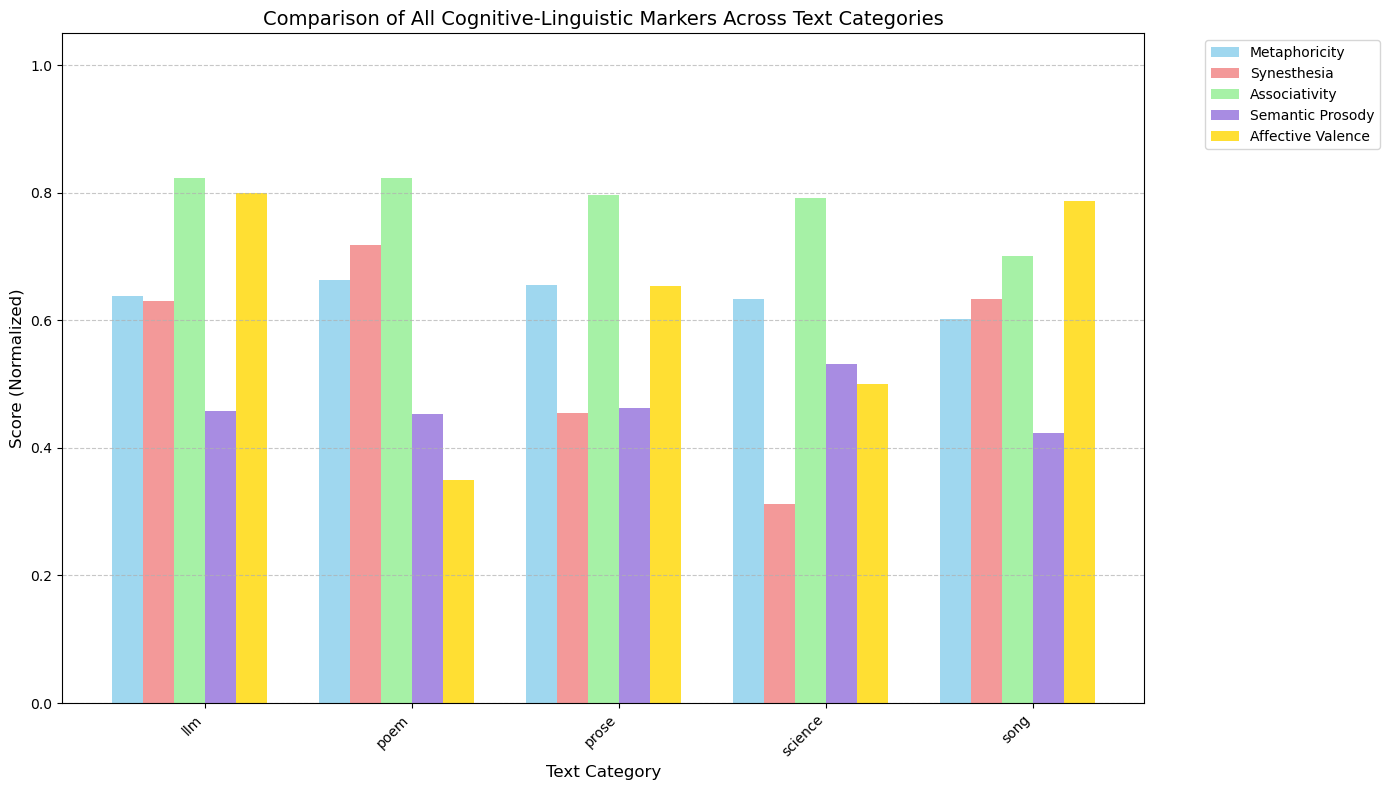

Plot saved as plots/all_markers_comparison.png


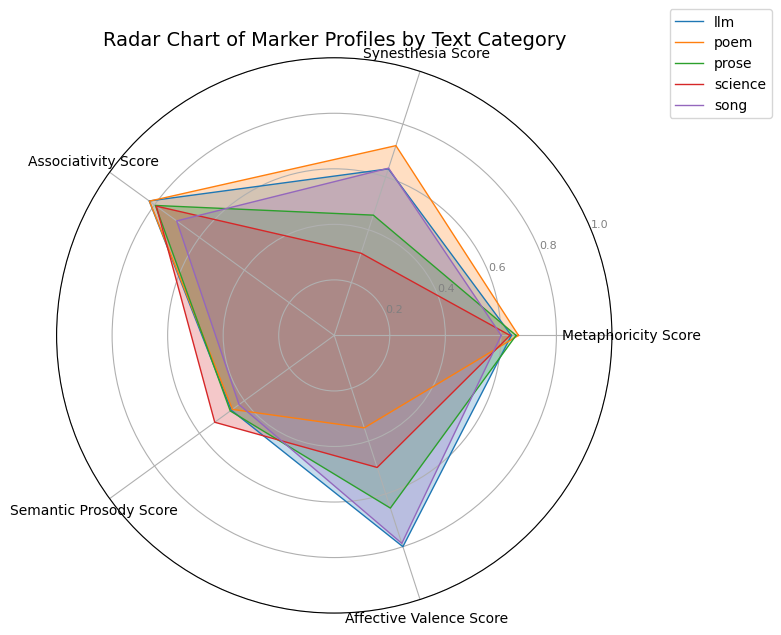

Plot saved as plots/radar_chart_comparison.png


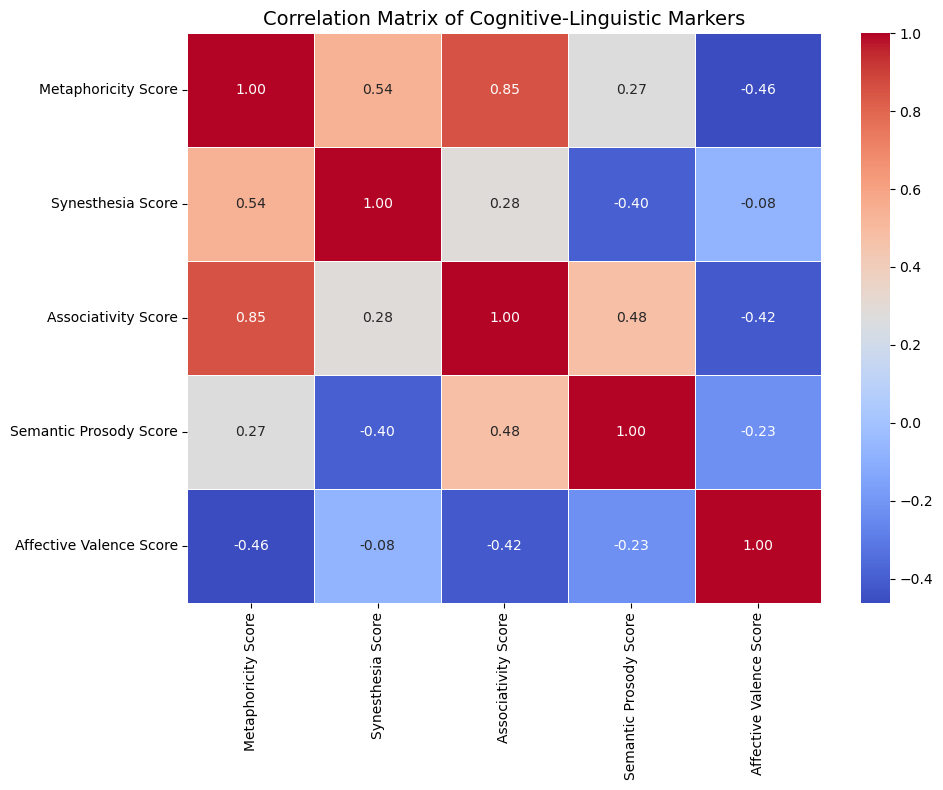

Plot saved as plots/marker_correlation_heatmap.png


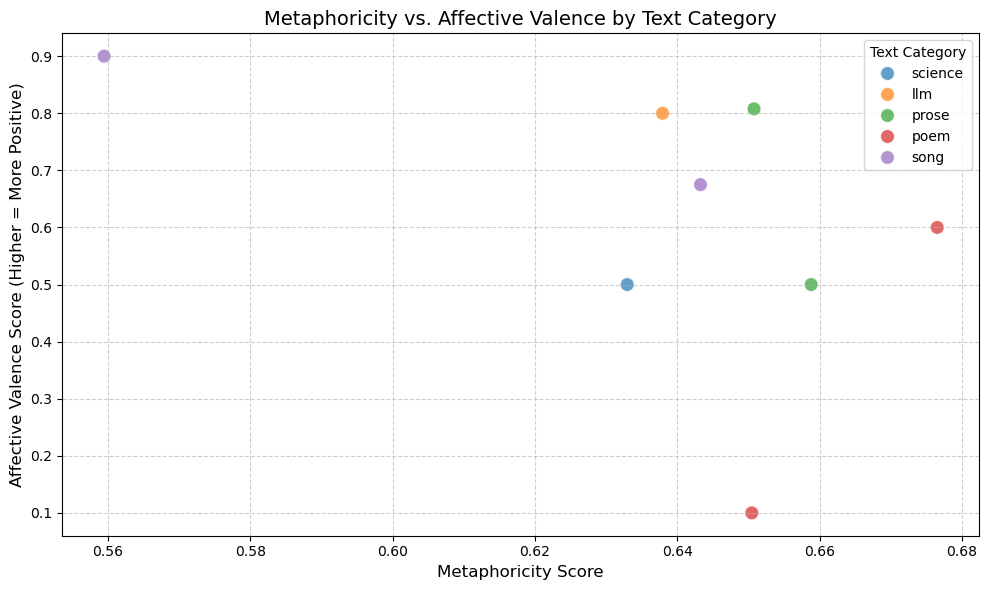

Plot saved as plots/metaphoricity_vs_valence_scatter.png


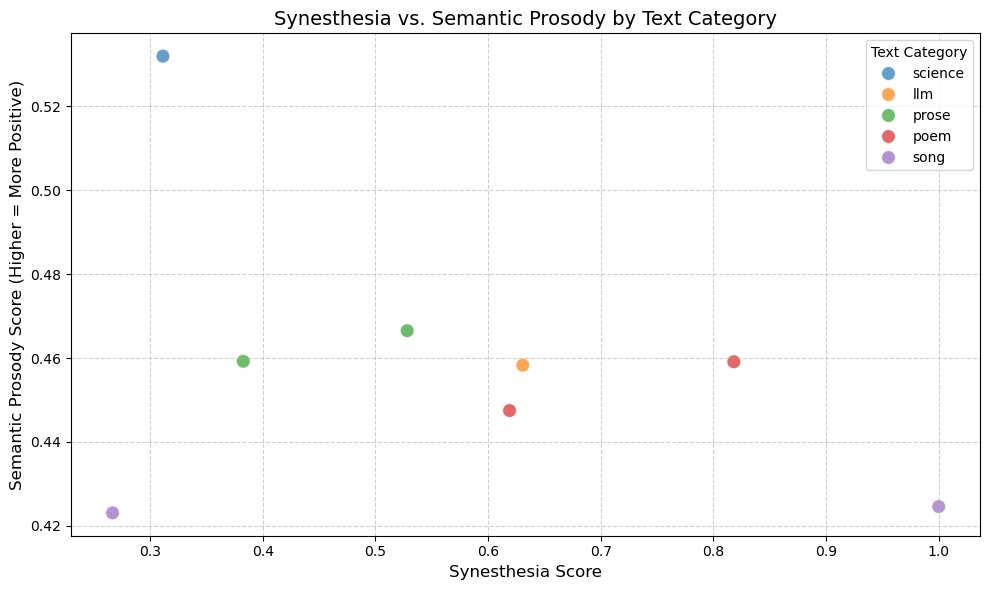

Plot saved as plots/synesthesia_vs_prosody_scatter.png

--- All plots generated and saved in 'plots/' directory. ---


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns # For more aesthetic plots

print("\n--- Creating enhanced plots ---")

# Ensure the 'plots' directory exists for saving images
os.makedirs('plots', exist_ok=True)

# Plot 1: Bar chart for all markers together
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = np.arange(len(df_category_avg['Text Category']))

plt.bar(index - 2*bar_width, df_category_avg['Metaphoricity Score'], bar_width, label='Metaphoricity', color='skyblue', alpha=0.8)
plt.bar(index - bar_width, df_category_avg['Synesthesia Score'], bar_width, label='Synesthesia', color='lightcoral', alpha=0.8)
plt.bar(index, df_category_avg['Associativity Score'], bar_width, label='Associativity', color='lightgreen', alpha=0.8)
plt.bar(index + bar_width, df_category_avg['Semantic Prosody Score'], bar_width, label='Semantic Prosody', color='mediumpurple', alpha=0.8) # New
plt.bar(index + 2*bar_width, df_category_avg['Affective Valence Score'], bar_width, label='Affective Valence', color='gold', alpha=0.8) # New

plt.xlabel('Text Category', fontsize=12)
plt.ylabel('Score (Normalized)', fontsize=12)
plt.title('Comparison of All Cognitive-Linguistic Markers Across Text Categories', fontsize=14)
plt.xticks(index + bar_width/2, df_category_avg['Text Category'], rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.05) # Scores are normalized to [0, 1]
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/all_markers_comparison.png')
plt.show()
print("Plot saved as plots/all_markers_comparison.png")

# Plot 2: Radar chart for a holistic view (more complex but good for comparison)

categories = df_category_avg['Text Category'].tolist()
N = len(df_category_avg.columns) - 1 # Number of markers

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1] # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Helper to plot a category on the radar chart
def plot_category_on_radar(ax, category_name, df, angles):
    values = df[df['Text Category'] == category_name].iloc[0, 1:].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=category_name)
    ax.fill(angles, values, alpha=0.25)

marker_columns = ['Metaphoricity Score', 'Synesthesia Score', 'Associativity Score', 'Semantic Prosody Score', 'Affective Valence Score']
ax.set_xticks(angles[:-1])
ax.set_xticklabels(marker_columns, fontsize=10)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], color='grey', size=8)
ax.set_ylim(0, 1)

for category in categories:
    plot_category_on_radar(ax, category, df_category_avg, angles)

ax.set_title('Radar Chart of Marker Profiles by Text Category', va='bottom', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig('plots/radar_chart_comparison.png')
plt.show()
print("Plot saved as plots/radar_chart_comparison.png")


# Plot 3: Heatmap for correlation between markers (optional but insightful)
plt.figure(figsize=(10, 8))
# Calculate correlations across the entire df_results (before averaging by category)
correlation_matrix = df_results[['Metaphoricity Score', 'Synesthesia Score', 'Associativity Score', 'Semantic Prosody Score', 'Affective Valence Score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Cognitive-Linguistic Markers', fontsize=14)
plt.tight_layout()
plt.savefig('plots/marker_correlation_heatmap.png')
plt.show()
print("Plot saved as plots/marker_correlation_heatmap.png")

# Plot 4: Scatter plots for specific marker relationships (e.g., Metaphoricity vs. Affective Valence)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Metaphoricity Score', y='Affective Valence Score', hue='Text Category', s=100, alpha=0.7)
plt.title('Metaphoricity vs. Affective Valence by Text Category', fontsize=14)
plt.xlabel('Metaphoricity Score', fontsize=12)
plt.ylabel('Affective Valence Score (Higher = More Positive)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('plots/metaphoricity_vs_valence_scatter.png')
plt.show()
print("Plot saved as plots/metaphoricity_vs_valence_scatter.png")


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Synesthesia Score', y='Semantic Prosody Score', hue='Text Category', s=100, alpha=0.7)
plt.title('Synesthesia vs. Semantic Prosody by Text Category', fontsize=14)
plt.xlabel('Synesthesia Score', fontsize=12)
plt.ylabel('Semantic Prosody Score (Higher = More Positive)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('plots/synesthesia_vs_prosody_scatter.png')
plt.show()
print("Plot saved as plots/synesthesia_vs_prosody_scatter.png")

print("\n--- All plots generated and saved in 'plots/' directory. ---")